In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")
from scipy.stats import chisquare

In [5]:
!mkdir output/04B.pair_annotation

mkdir: cannot create directory ‘output/04B.pair_annotation’: File exists


In [6]:
snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv", index_col=0)
snps_columns_to_keep = [
    "pos", 
    "gene_name", 
    "gene_id", 
    "is_lineage",
    "in_antigen_epitope",
    "in_antigen_protein", 
    "in_known_ABR_position",
    "known_drug", 
    "in_possible_ABR_gene", 
    "possible_drug"

]

# Add gene and lineage  annotation to the results
results = pd.read_csv("output/02B.comutation_pvalues/results_file_allpairs.csv")
results = results.merge(snps[snps_columns_to_keep], left_on="position_i", right_on="pos")
results = results.merge(snps[snps_columns_to_keep], left_on="position_j", right_on="pos", suffixes=["_i", "_j"])
results.columns

print("total pairs", len(results))
print("total non-lineage pairs", len(results.query("not is_lineage_i and not is_lineage_j")))

results = results.query("not is_lineage_i and not is_lineage_j")

results = results[[
   'position_i', 'gene_name_i','position_j', 'gene_name_j',
    'n_mutations_i',
   'n_mutations_j', 'n_branches_with_i', 'n_branches_with_j',
   'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i', 'n_muts_same_branch',
   'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
   'pval_beta_i_on_j', 'BH_critical_value', 'pval_beta_i_on_j_BH_sig',
    'is_lineage_i','is_lineage_j',
    'gene_id_i', 'gene_id_j', 
    "in_antigen_epitope_i",
    "in_antigen_protein_i", 
    "in_known_ABR_position_i",
    "known_drug_i", 
    "in_possible_ABR_gene_i", 
    "possible_drug_i",
    "in_antigen_epitope_j",
    "in_antigen_protein_j", 
    "in_known_ABR_position_j",
    "known_drug_j", 
    "in_possible_ABR_gene_j", 
    "possible_drug_j"
]]
results.to_csv("output/04B.pair_annotation/results_allpairs_annotated.csv")

print("total_significant", len(results.query("pval_beta_i_on_j_BH_sig")))
results.query("pval_beta_i_on_j_BH_sig").to_csv("output/04B.pair_annotation/results_significant_annotated.csv")

total pairs 156100
total non-lineage pairs 139048
total_significant 63271


In [7]:
63271/139048

0.4550299177262528

## Overall analysis of hits

In [8]:
def annotate(top_hits):
    def _separate_hits(logic_columns, current_df):
        is_hit = np.sum(current_df[logic_columns].values, axis=1) > 0

        hit_df = current_df.iloc[is_hit, :]
        current_df = current_df.iloc[~is_hit, :]
        return hit_df, current_df

    # start with the df of top hits. Get just the known antibiotic hits
    top_hits["annotation"] = 'other'
    logic_columns = ["in_known_ABR_position_i", "in_known_ABR_position_j"]

    antibiotic_hits, current_df = _separate_hits(logic_columns, top_hits)

    # if both are antibiotic, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "between_known_AB"

    # if just one, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            ~antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_second"

    antibiotic_hits.loc[
        np.logical_and(
            ~antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_first"

    # Then get the antigen proteins
    logic_columns = ['in_antigen_protein_i','in_antigen_protein_j',]

    antigen_hits, current_df = _separate_hits(logic_columns, current_df)

    # if just one, annotate that
    antigen_hits.loc[
        np.logical_or(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "one_antigen"

    antigen_hits.loc[
        np.logical_and(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "both_antigen"

    # then get the maybe antibiotic hits
    logic_columns = ["in_possible_ABR_gene_i", "in_possible_ABR_gene_j"]

    maybe_antibiotic_hits, current_df = _separate_hits(logic_columns, current_df)

    # if both are antibiotic, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "between_maybe_AB"

    # if just one, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            ~maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_second"

    maybe_antibiotic_hits.loc[
        np.logical_and(
            ~maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_first"

    return pd.concat([antigen_hits, antibiotic_hits, maybe_antibiotic_hits, current_df])

In [9]:
top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated.csv")
top_hits = annotate(top_hits)
top_hits.to_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv")
top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv", index_col=0)

In [10]:
print(top_hits.groupby("annotation").size())

annotation
between_known_AB     1145
between_maybe_AB     1575
both_antigen         4093
known_AB_first       3238
known_AB_second      2802
maybe_AB_first       3219
maybe_AB_second      1504
one_antigen         16144
other               29551
dtype: int64


In [11]:
top_hits.sort_values("pval_beta_i_on_j")[[
    "position_i",  "gene_name_i", "position_j", "gene_name_j", 
    "n_mutations_i", "n_mutations_j", "n_muts_same_branch", "pval_beta_i_on_j", "annotation"
]].head(50)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_muts_same_branch,pval_beta_i_on_j,annotation
31735,105060,Rv0095c,105063,Rv0095c,345,333,324,0.000000e+00,other
0,761155,rpoB,2155168,katG,1487,1811,569,0.000000e+00,between_known_AB
13427,1341114,esxL,1341120,esxL,181,218,164,4.940656e-323,both_antigen
13544,2197331,Rv1945,2197332,Rv1945,123,125,121,4.850264e-275,both_antigen
7324,3847215,PPE59,3847221,PPE59,149,134,125,9.116068e-269,other
8898,3841652,None,3841654,None,114,114,113,6.451416e-262,other
14466,1341099,esxL,1341114,esxL,194,181,133,3.728245e-257,both_antigen
13428,1341099,esxL,1341120,esxL,194,218,132,7.819885e-244,both_antigen
3648,1339435,PPE18,1339436,PPE18,105,113,103,2.841233e-236,both_antigen
3345,1339432,PPE18,1339435,PPE18,109,105,102,3.577330e-235,both_antigen


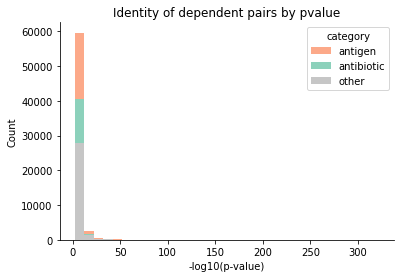

In [12]:

# Create beautiful perfect color palette
pal = sns.color_palette("Set2")
figure = plt.figure()
ax = figure.gca()
top_hits["log_pval"] = -np.log10(top_hits.pval_beta_i_on_j)
for_display = top_hits
for_display["category"] = for_display.annotation
for_display["category"] = ["antibiotic" if x in ["known_AB_second", "between_known_AB", "known_AB_first", "maybe_AB_second", "between_maybe_AB", "maybe_AB_first"] else x for x in for_display.category]
for_display["category"] = ["antigen" if x in ["one_antigen", "both_antigen"] else x for x in for_display.category]

sns.histplot(
    data = for_display, x="log_pval", multiple='stack',
    hue="category", 
    binwidth=10, 
    log_scale=[False,False], 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
               "other":pal[7]
              },
    linewidth=0
)
ax.set_xlabel("-log10(p-value)")
ax.set_title("Identity of dependent pairs by pvalue")
sns.despine()
#plt.savefig("figures/identity_by_occurrence.pdf")

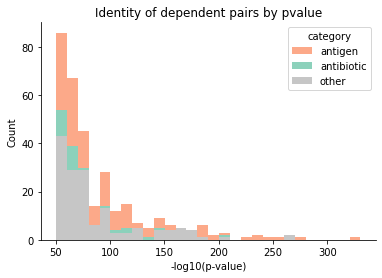

In [13]:

figure = plt.figure()
ax = figure.gca()
#top_hits["log_pval"] = -np.log10(top_hits.pval_beta_i_on_j)

for_display = for_display.query("log_pval > 50")

sns.histplot(
    data = for_display, x="log_pval", multiple='stack',
    hue="category", 
    binwidth=10, 
    log_scale=[False,False], 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
               "other":pal[7]
              },
    linewidth=0
)
ax.set_xlabel("-log10(p-value)")
ax.set_title("Identity of dependent pairs by pvalue")
# ax.set_xlim([20,250])
# ax.set_ylim([0,3000])
sns.despine()
#plt.savefig("figures/identity_by_occurrence.pdf")

In [14]:
def dist(p1,p2):
    
    total_nucleotides = 4411532    

    max_dist = int(total_nucleotides / 2)
    # accounts for circularization of genome
    d1 = np.abs(p1 - p2)
    
    #print(i,j,d1)
    if d1 > max_dist:
        i,j=sorted([p1,p2])
        #print("too_far!", d1)
        i = i + total_nucleotides
        d1 = i-j
        #print("new distance", d1)
        
    return d1


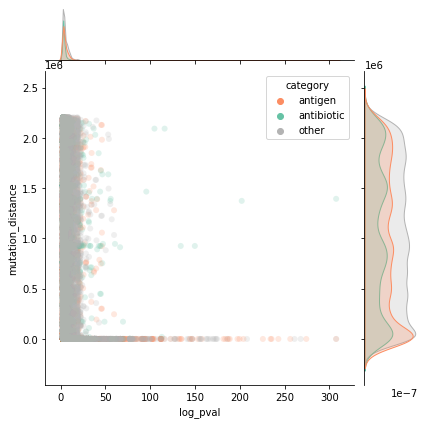

In [15]:
import sys
for_display = top_hits
for_display["category"] = for_display.annotation
for_display["category"] = ["antibiotic" if x in ["known_AB_second", "between_known_AB", "known_AB_first", "maybe_AB_second", "between_maybe_AB", "maybe_AB_first"] else x for x in for_display.category]
for_display["category"] = ["antigen" if x in ["one_antigen", "both_antigen"] else x for x in for_display.category]

for_display["mutation_distance"]=[dist(x,y) for x,y in zip(for_display.position_i, for_display.position_j)]
for_display["log_pval"] = -np.log10(for_display.pval_beta_i_on_j + sys.float_info.min)
sns.jointplot(
    data = for_display, x="log_pval",  y="mutation_distance",
    hue="category", 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
               "other":pal[7]
              },
    linewidth=0,
    alpha=0.2
)                         

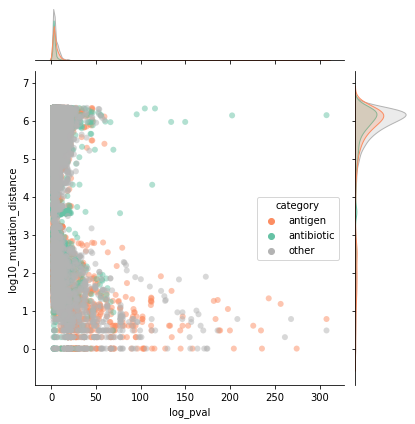

In [16]:
import sys
for_display["log2_mutation_distance"]=[np.log2(d) for d in for_display.mutation_distance]
for_display["log10_mutation_distance"]=[np.log10(d) for d in for_display.mutation_distance]
for_display["log_pval"] = -np.log10(for_display.pval_beta_i_on_j + sys.float_info.min)

sns.jointplot(
    data = for_display, x="log_pval",  y="log10_mutation_distance",
    hue="category", 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
              "between":pal[2], 
               "other":pal[7]
              },
    linewidth=0,
    alpha=0.5
)     

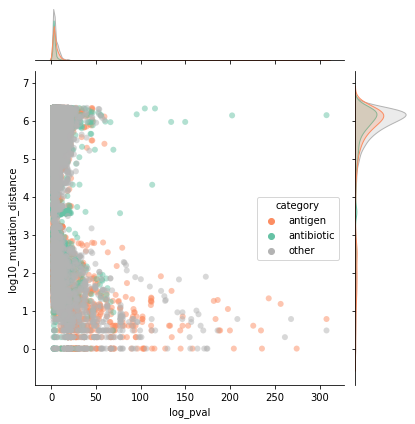

In [17]:
import sys
for_display = top_hits
for_display["category"] = for_display.annotation
for_display["category"] = ["antibiotic" if x in ["known_AB_second", "between_known_AB", "known_AB_first", "maybe_AB_second", "between_maybe_AB", "maybe_AB_first"] else x for x in for_display.category]
for_display["category"] = ["antigen" if x in ["one_antigen", "both_antigen"] else x for x in for_display.category]


#for_display = for_display.query("log_pval > 50")
for_display["log2_mutation_distance"]=[np.log2(dist(x,y)) for x,y in zip(for_display.position_i, for_display.position_j)]
for_display["log10_mutation_distance"]=[np.log10(d) for d in for_display.mutation_distance]
for_display["mutation_distance"]=[dist(x,y) for x,y in zip(for_display.position_i, for_display.position_j)]
for_display["log_pval"] = -np.log10(for_display.pval_beta_i_on_j + sys.float_info.min)

sns.jointplot(
    data = for_display, x="log_pval",  y="log10_mutation_distance",
    hue="category", 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
              "between":pal[2], 
               "other":pal[7]
              },
    linewidth=0,
    alpha=0.5
)     

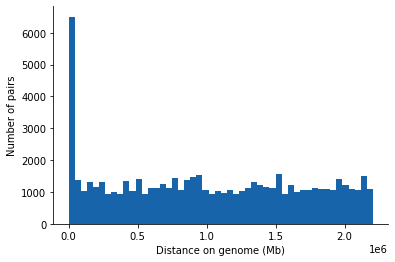

In [18]:

pal = sns.color_palette("Blues",4)

for_display = top_hits
for_display["mutation_distance"] = [dist(x,y) for x,y in zip(for_display.position_i, for_display.position_j)]
figure = plt.figure()
ax = figure.gca()

ax.hist(for_display.mutation_distance, 50, color=pal[3])
plt.xlabel("Distance on genome (Mb)")
plt.ylabel("Number of pairs")
sns.despine()
#plt.show()
plt.savefig("figures/simultaneous_mutations_distance.pdf")

## Enrichment statistics

In [19]:

all_hits = pd.read_csv("output/04B.pair_annotation/results_allpairs_annotated.csv")

all_hits = annotate(all_hits)
all_hits.to_csv("output/04B.pair_annotation/results_allpairs_annotation_withcategories.csv")
print(all_hits.groupby("annotation").size())

annotation
between_known_AB     3329
between_maybe_AB     2289
both_antigen        10111
known_AB_first      13179
known_AB_second     14752
maybe_AB_first       6061
maybe_AB_second      2923
one_antigen         39779
other               46625
dtype: int64


#### Question 1: are the overlapping hits an enrichment in some way based on our expectation from the distribution of SNPs?

In [41]:


## Actual numbers: 162 epitopes, 804 antigens, 250 known resistance, 813 possible resistance, 2747 no category
total_snps = 4776

p_epitope = 162/total_snps
p_antigen = 804/total_snps
p_known_R = 250/total_snps
p_possible_R = (813-250)/total_snps
p_other = (total_snps - 804 - 813)/total_snps

# bang this out
e_between_known_AB = p_known_R * p_known_R
e_between_maybe_AB = p_possible_R * p_possible_R
e_both_antigen = p_antigen * p_antigen

e_known_AB_first = p_known_R * (1-p_known_R)
e_known_AB_second = p_known_R * (1-p_known_R)

e_maybe_AB_first = p_possible_R * (p_other)
e_maybe_AB_second = p_possible_R * (p_other)

e_one_antigen = 2 * p_antigen * (p_other + p_possible_R)
e_other = p_other * p_other


top_hits_values = all_hits.groupby("annotation").size()
labels = all_hits.groupby("annotation").size().index

all_hits_expectation = np.array([e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
                        e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other]) * len(all_hits)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

print(result_df)
result_df1 = result_df
result_df1["chi_square"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[0]
result_df1["p_value"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[1]

result_df1.to_csv("output/04B.chisquare_all_pairs_vs_expected.csv")

Power_divergenceResult(statistic=58711.77765177365, pvalue=0.0)
                  actual_pair_freq  expected_pair_freq
annotation                                            
between_known_AB              3329          380.992238
between_maybe_AB              2289         1932.203658
both_antigen                 10111         3940.471655
known_AB_first               13179         6897.483474
known_AB_second              14752         6897.483474
maybe_AB_first                6061        10841.618750
maybe_AB_second               2923        10841.618750
one_antigen                  39779        36483.670396
other                        46625        60832.457605


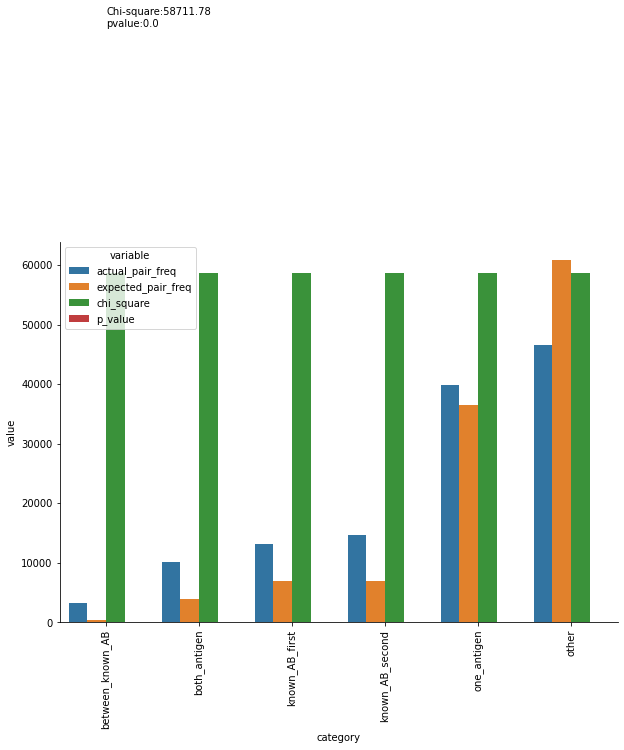

In [21]:
## Make a bar chart of actual vs. observations

result_df["category"] = result_df.index
cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
result_df = result_df.query("category not in @cats_to_remove")
to_plot = result_df.melt(["category"])
#to_plot["value"] = [np.log10(x) for x in to_plot.value]

fig= plt.figure(figsize=(10,7))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value', hue='variable')
plt.xticks(rotation=90)
cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

ax.text(x = 0, y=100000, s=f"Chi-square:{np.round(cs.statistic,2)}\npvalue:{cs.pvalue}")
sns.despine()

In [22]:
from scipy.stats import chisquare

top_hits_values = top_hits.groupby("annotation").size().values
all_hits_expectation = all_hits.groupby("annotation").size().values / len(all_hits) * len(top_hits)

print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

## Table of nice results

result_df = pd.DataFrame({ 
    "category": top_hits.groupby("annotation").size().index,
    "actual_hit_freq": top_hits_values, 
    "expected_hit_freq": all_hits_expectation})

print(result_df)
result_df2 = result_df

Power_divergenceResult(statistic=7553.019690179897, pvalue=0.0)
           category  actual_hit_freq  expected_hit_freq
0  between_known_AB             1145        1514.794596
1  between_maybe_AB             1575        1041.563482
2      both_antigen             4093        4600.807498
3    known_AB_first             3238        5996.839286
4   known_AB_second             2802        6712.601346
5    maybe_AB_first             3219        2757.936331
6   maybe_AB_second             1504        1330.052450
7       one_antigen            16144       18100.635097
8             other            29551       21215.769914


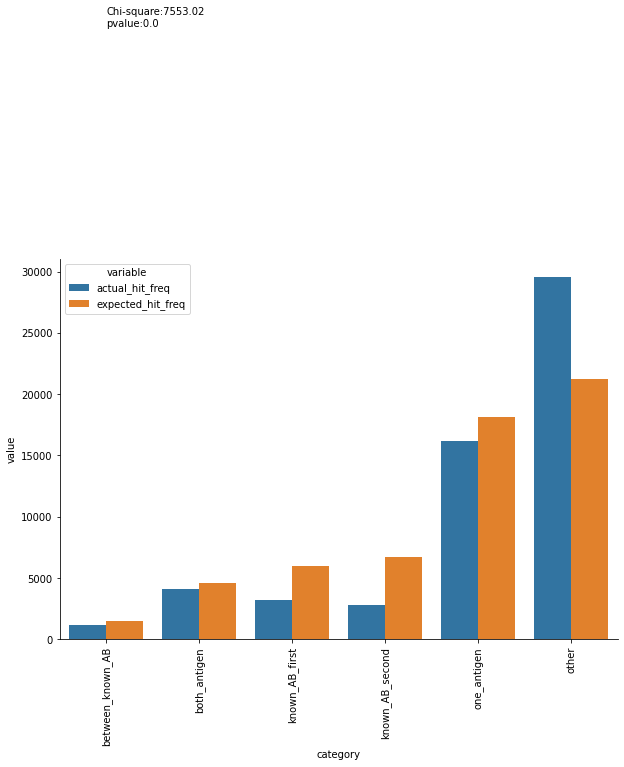

In [23]:
## Make a bar chart of actual vs. observations

cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
result_df = result_df.query("category not in @cats_to_remove")
to_plot = result_df.melt(["category"])
#to_plot["value"] = [np.log10(x) for x in to_plot.value]

fig= plt.figure(figsize=(10,7))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value', hue='variable')
plt.xticks(rotation=90)
cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

ax.text(x = 0, y=50000, s=f"Chi-square:{np.round(cs.statistic,2)}\npvalue:{cs.pvalue}")
sns.despine()

In [24]:
 top_hits.query("mutation_distance < 100").groupby("annotation").size()

annotation
between_known_AB      35
between_maybe_AB     194
both_antigen        1293
known_AB_first         5
known_AB_second        9
one_antigen           17
other               1051
dtype: int64

In [25]:
top_hits.iloc[0:100].groupby("annotation").size()

annotation
both_antigen     8
one_antigen     92
dtype: int64

In [26]:
top_hits.groupby("annotation").size()

annotation
between_known_AB     1145
between_maybe_AB     1575
both_antigen         4093
known_AB_first       3238
known_AB_second      2802
maybe_AB_first       3219
maybe_AB_second      1504
one_antigen         16144
other               29551
dtype: int64

In [27]:
from scipy.stats import chisquare

top_hits=top_hits.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()
all_hits_expectation = top_hits.groupby("annotation").size() / len(top_hits) * 100

print(chisquare([  8, 0, 51,  0, 0, 0, 0,  0, 41],  f_exp=all_hits_expectation))

## Table of nice results


result_df = pd.DataFrame({ 
    #"category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq": top_hits_values, 
    "expected_top_hit_freq": all_hits_expectation})

print(result_df)
result_df3 = result_df
result_df3["category"] = result_df3.index

Power_divergenceResult(statistic=373.4284880308963, pvalue=8.982798796970833e-76)
                  actual_top_hit_freq  expected_top_hit_freq
annotation                                                  
between_known_AB                  8.0               1.809676
between_maybe_AB                  NaN               2.489292
both_antigen                     51.0               6.468998
known_AB_first                    NaN               5.117668
known_AB_second                   NaN               4.428569
maybe_AB_first                    NaN               5.087639
maybe_AB_second                   NaN               2.377076
one_antigen                       NaN              25.515639
other                            41.0              46.705442


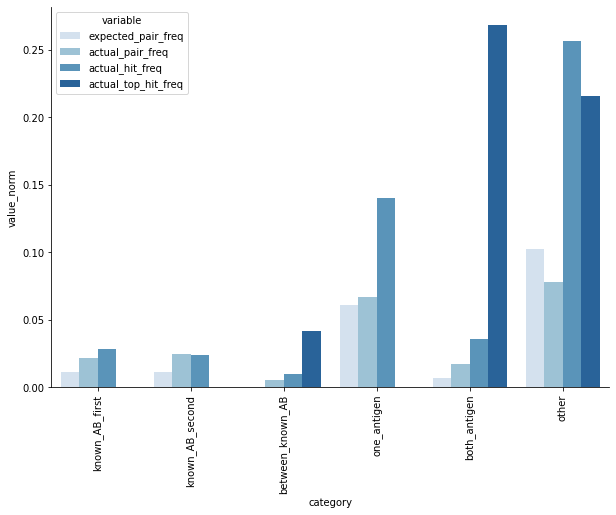

In [28]:
### Combine all three into bar plot
def _process_result_df(result_df):
    cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
    result_df = result_df.query("category not in @cats_to_remove")

    desired_order = ["known_AB_first", "known_AB_second", "between_known_AB","one_antigen", "both_antigen", "other"]


    to_plot = result_df.melt(["category"])
    to_plot["category_sorter"] = [desired_order.index(x) for x in to_plot.category]
    #to_plot["value"] = [np.log10(x) for x in to_plot.value]

    # normalize the result dataframe
    to_plot["value_norm"] = to_plot.value / to_plot.value.sum()
    
    return to_plot

pal = sns.color_palette("Blues",4)

toplot1 = _process_result_df(result_df1)
toplot2 = _process_result_df(result_df2)
toplot3 = _process_result_df(result_df3)

to_plot = pd.concat([toplot1, toplot2, toplot3])

categories_to_keep = ["expected_pair_freq", "actual_pair_freq", "actual_hit_freq", "actual_top_hit_freq"]
to_plot = to_plot.query("variable in @categories_to_keep")

desired_order = ["expected_pair_freq", "actual_pair_freq", "actual_hit_freq", "actual_top_hit_freq"]
to_plot["sorter"] = [desired_order.index(x) for x in to_plot.variable]
to_plot = to_plot.sort_values(["sorter", "category_sorter"])


fig= plt.figure(figsize=(10,7))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable',
            palette=pal
            
           )
plt.xticks(rotation=90)
#cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

sns.despine()
#plt.savefig(

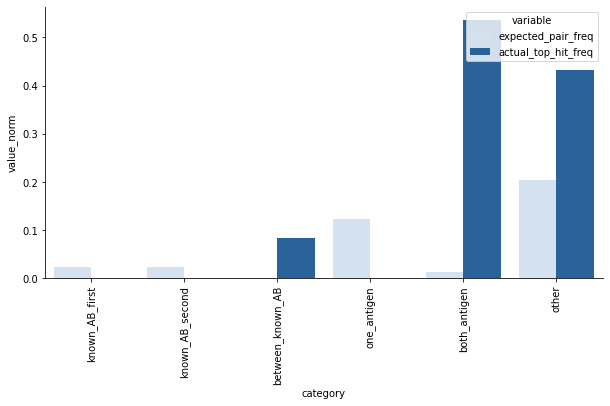

In [29]:
### Combine all three into bar plot
def _process_result_df(result_df):
    cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
    result_df = result_df.query("category not in @cats_to_remove")

    desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "one_antigen","both_antigen",  "other"]


    to_plot = result_df.melt(["category"])
    to_plot["category_sorter"] = [desired_order.index(x) for x in to_plot.category]
    #to_plot["value"] = [np.log10(x) for x in to_plot.value]

    # normalize the result dataframe
    to_plot["value_norm"] = to_plot.value / (to_plot.value.sum()/2)
    
    return to_plot

pal = sns.color_palette("Blues",4)

toplot1 = _process_result_df(result_df1)
toplot2 = _process_result_df(result_df2)
toplot3 = _process_result_df(result_df3)

to_plot = pd.concat([toplot1, toplot2, toplot3])

categories_to_keep = ["expected_pair_freq", "actual_top_hit_freq"]
to_plot = to_plot.query("variable in @categories_to_keep")

desired_order = ["expected_pair_freq", "actual_pair_freq", "actual_hit_freq", "actual_top_hit_freq"]
to_plot["sorter"] = [desired_order.index(x) for x in to_plot.variable]
to_plot = to_plot.sort_values(["sorter", "category_sorter"])


fig= plt.figure(figsize=(10,5))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable',
            palette=[pal[0], pal[3]]
            
           )
plt.xticks(rotation=90)
#cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

sns.despine()
plt.savefig("figures/simultaneous_mutations_category.pdf")

## Repeat enrichment analysis treating the proximal mutations as separate

In [30]:
all_hits["mutation_distance"]=[dist(x,y) for x,y in zip(all_hits.position_i, all_hits.position_j)]

all_hits_close = all_hits.query("mutation_distance <= 100")
all_hits_far = all_hits.query("mutation_distance > 100")
print(len(all_hits_close), len(all_hits_far))

2870 136178


In [31]:
top_hits_values

top_hits_values.values

array([ 8, 51, 41])

In [33]:
top_hits_values = all_hits_close.groupby("annotation").size()
top_hits_values = [  69,  199, 1421,   15,   19,  0, 0, 37, 1110]
labels = all_hits_close.groupby("annotation").size().index

all_hits_close_expectation = np.array([e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
                        e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other]) * len(all_hits_close)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_close_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_close_expectation))

print(result_df)
results_df1_close = result_df
#result_df1_close["category"] = 

Power_divergenceResult(statistic=24542.533843098314, pvalue=0.0)
   actual_pair_freq  expected_pair_freq
0                69            7.863815
1               199           39.881368
2              1421           81.332731
3                15          142.366503
4                19          142.366503
5                 0          223.774853
6                 0          223.774853
7                37          753.035887
8              1110         1255.603485


In [34]:
top_hits_values = all_hits_far.groupby("annotation").size()

labels = all_hits_far.groupby("annotation").size().index

all_hits_far_expectation = np.array([e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
                        e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other]) * len(all_hits_far)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_far_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_far_expectation))

print(result_df)
results_df1_far = result_df

Power_divergenceResult(statistic=55207.35931797756, pvalue=0.0)
                  actual_pair_freq  expected_pair_freq
annotation                                            
between_known_AB              3260          373.128423
between_maybe_AB              2090         1892.322290
both_antigen                  8690         3859.138923
known_AB_first               13164         6755.116971
known_AB_second              14733         6755.116971
maybe_AB_first                6061        10617.843897
maybe_AB_second               2923        10617.843897
one_antigen                  39742        35730.634508
other                        45515        59576.854121


In [36]:

top_hits=all_hits_close.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()

all_hits_expectation = all_hits_close.groupby("annotation").size() / len(top_hits) * 100

print(chisquare([  0, 0, 56,  0, 0,  0, 44],  f_exp=all_hits_expectation))

## Table of nice results


result_df = pd.DataFrame({ 
    #"category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq_close": top_hits_values, 
    "expected_top_hit_freq_close": all_hits_expectation})

print(result_df)
results_df3_close = result_df
results_df3_close["category"] = results_df3_close.index

Power_divergenceResult(statistic=13.394867971419693, pvalue=0.03717679652128256)
                  actual_top_hit_freq_close  expected_top_hit_freq_close
annotation                                                              
between_known_AB                        NaN                     2.404181
between_maybe_AB                        NaN                     6.933798
both_antigen                           56.0                    49.512195
known_AB_first                          NaN                     0.522648
known_AB_second                         NaN                     0.662021
one_antigen                             NaN                     1.289199
other                                  44.0                    38.675958


In [38]:

top_hits=all_hits_far.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()

all_hits_expectation = all_hits_far.groupby("annotation").size() / len(top_hits) * 100

#top_hits_values
print(chisquare([26,  2, 15,  1,  1,  5, 20, 0, 30],  f_exp=all_hits_expectation))

## Table of nice results


result_df = pd.DataFrame({ 
    #"category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq_far": top_hits_values, 
    "expected_top_hit_freq_far": all_hits_expectation})

print(result_df)
results_df3_far = result_df
results_df3_far["category"] = results_df3_far.index
results_df3_far

Power_divergenceResult(statistic=439.3406595229175, pvalue=7.103875869661221e-90)
                  actual_top_hit_freq_far  expected_top_hit_freq_far
annotation                                                          
between_known_AB                     26.0                   2.393926
between_maybe_AB                      2.0                   1.534756
both_antigen                         15.0                   6.381354
known_AB_first                        1.0                   9.666760
known_AB_second                       1.0                  10.818928
maybe_AB_first                        5.0                   4.450792
maybe_AB_second                       NaN                   2.146455
one_antigen                          20.0                  29.183862
other                                30.0                  33.423167


,actual_top_hit_freq_far,expected_top_hit_freq_far,category
annotation,,,
between_known_AB,26.0,2.393926,between_known_AB
between_maybe_AB,2.0,1.534756,between_maybe_AB
both_antigen,15.0,6.381354,both_antigen
known_AB_first,1.0,9.666760,known_AB_first
known_AB_second,1.0,10.818928,known_AB_second
maybe_AB_first,5.0,4.450792,maybe_AB_first
maybe_AB_second,NaN,2.146455,maybe_AB_second
one_antigen,20.0,29.183862,one_antigen
other,30.0,33.423167,other


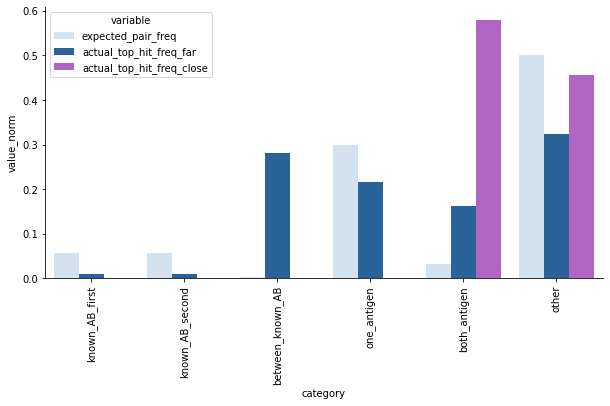

In [40]:
### Combine all three into bar plot
def _process_result_df(result_df):
    cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
    result_df = result_df.query("category not in @cats_to_remove")

    desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "one_antigen","both_antigen",  "other"]


    to_plot = result_df.melt(["category"])
    to_plot["category_sorter"] = [desired_order.index(x) for x in to_plot.category]
    #to_plot["value"] = [np.log10(x) for x in to_plot.value]

    # normalize the result dataframe
    to_plot["value_norm"] = to_plot.value / (to_plot.value.sum()/2)
    
    return to_plot

pal = sns.color_palette("Blues",4)

results_df1_far["category"] = results_df3_far.index

toplot1 = _process_result_df(results_df1_far).fillna(0)
toplot2 = _process_result_df(results_df3_close).fillna(0)
toplot3 = _process_result_df(results_df3_far).fillna(0)

to_plot = pd.concat([toplot1, toplot2, toplot3])

categories_to_keep = ["expected_pair_freq", "actual_top_hit_freq_far", "actual_top_hit_freq_close"]
to_plot = to_plot.query("variable in @categories_to_keep")

desired_order = ["expected_pair_freq", "actual_top_hit_freq_far",  "actual_top_hit_freq_close"]
to_plot["sorter"] = [desired_order.index(x) for x in to_plot.variable]
to_plot = to_plot.sort_values(["sorter", "category_sorter"])


fig= plt.figure(figsize=(10,5))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable',
            palette=[pal[0], pal[3],"mediumorchid"]
            
           )
plt.xticks(rotation=90)
#cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

sns.despine()
plt.savefig("figures/simultaneous_mutations_far_category.pdf")